In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-11-13 12:06:54.827590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 12:06:55.450401: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 12:06:56.882641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tharci/anaconda3/lib/
2022-11-13 12:06:56.884412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: c

In [2]:
from __future__ import print_function
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from preprocess import *
from utils import *
import math

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Image loading and preprocessing


In [14]:
crop_size = (256, 256)

def preprocess_generator_train_test(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], crop_size[0], crop_size[1], 3))
        for i in range(batch.shape[0]):
            batch_crops[i] = crop_img(batch[i], crop_size)
            batch_crops[i] = center_img(batch_crops[i]) # shift to -1,1
        yield batch_crops, batch_crops


def slice_img(img, slice_size):
    padded_size = (math.ceil(img.shape[0] / float(slice_size[0])) * slice_size[0],
                math.ceil(img.shape[1] / float(slice_size[1])) * slice_size[1],
                img.shape[2])

    padded_img = np.zeros(padded_size)
    padded_img[0:img.shape[0], 0:img.shape[1]] = img
    M, N = slice_size
    slices = np.array(
            [padded_img[x:x+M, y:y+N] for x in range(0, padded_img.shape[0], M)
                                      for y in range(0, padded_img.shape[1], N)]
    )
    return slices


def deslice_img(slices, img_size):
    slice_size = slices[0].shape
    img = np.zeros(img_size)

    y, x = 0, 0
    for s in slices:
        y_to = min(y+slice_size[0], img.shape[0])
        x_to = min(x+slice_size[1], img.shape[1])
        img[y:y_to, x:x_to] = s[0:y_to-y, 0:x_to-x]
        if x + slice_size[1] >= img.shape[1]:
            x = 0
            y += slice_size[0]
        else:
            x += slice_size[1]

    return img


def preprocess_generator_slice(generator):
    while True:
        batch = next(generator)
        for img in batch:
            img = center_img(img)
            yield slice_img(img, crop_size)


### 720p
image_width_target = 1280 // 2
image_height_target = 720 // 2

train_ds, test_ds = create_dataflows('../images/HollowKnight/', (image_height_target, image_width_target), 16)

train_ds_prep = preprocess_generator_train_test(train_ds)
test_ds_prep = preprocess_generator_train_test(test_ds)

### 1080p
# image_width_target = 1280
# image_height_target = 720
#
# train_ds, test_ds = create_dataflows('../images/HollowKnight-1080p/', (image_height_target, image_width_target), 16)
#
# train_ds_prep = preprocess_generator_train_test(train_ds)
# test_ds_prep = preprocess_generator_train_test(test_ds)

# train_ds_mapped = pair_mapping(train_ds)
# test_ds_mapped = pair_mapping(test_ds)

Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


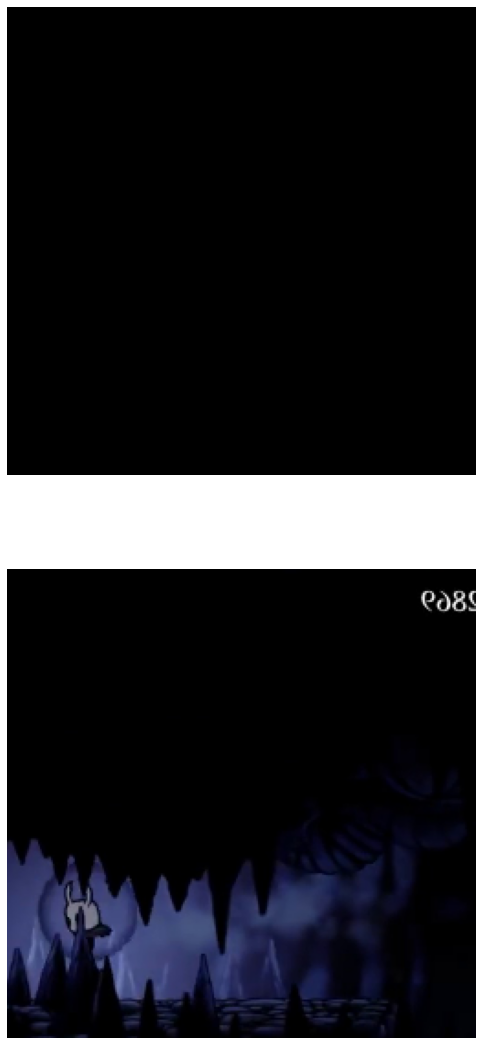

In [15]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:2]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(decenter_img(image))
    plt.axis("off")

train_ds.reset()

# The Model of the AutoEncoder

In [16]:
def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(decenter_img(y_true), decenter_img(y_pred), 1.0, filter_size=3))

total_variation_weight = 1e-10

def tv_loss(y_true, y_pred):
    # tv = tf.reduce_sum(tf.image.total_variation(decenter_img(y_pred))) # tv1: total var of y_pred
    # tv = tf.reduce_sum(tf.image.total_variation(tf.abs(decenter_img(y_pred) - decenter_img(y_true)))) # tv3, no high hopes, just bull
    tv = tf.nn.relu(tf.reduce_sum(tf.image.total_variation(decenter_img(y_pred))) - tf.reduce_sum(tf.image.total_variation(decenter_img(y_true)))) # tv4
    return ssim_loss(y_true, y_pred) + total_variation_weight * tv

In [38]:
from keras import backend as K, losses
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from keras.models import Model, Sequential

def create_improved_baseline_model_12x_comp(image_size):
    ### Encoder ###

    model = Sequential()
    model.add(Conv2D(16, kernel_size=(7, 7), strides=(2, 2), kernel_initializer='he_normal',
                     padding='same', input_shape=(image_size[0], image_size[1], 3)))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(8, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu', name='encoded', dtype='float16'))


    ### Decoder ###

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')) #
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu')) #

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')) #
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu')) #

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')) #
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu')) #

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization()) #
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), activation='tanh', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model

In [39]:
autoencoder = create_improved_baseline_model_12x_comp(crop_size)
# autoencoder.summary()

('shape of encoded', (None, 32, 32, 8))
('shape of decoded', (None, 256, 256, 3))


In [40]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0025), loss=ssim_loss)

# Training the AutoEncoder

In [41]:
# Note: Delete the logs before running this. The command below should do this, but I would prefer to do it manually.
# !RMDIR "./logs/" /S /Q

# Launching Tensorboard
%tensorboard --logdir ./logs/fit --host localhost #--port:6006
# localhost:6006 in browser

Launching TensorBoard...

In [42]:
from keras.callbacks import CSVLogger, TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Set APPEND=TRUE if you are continuing the training, so that the log.csv wouldn't be reset!
csv_logger = CSVLogger('log.csv', append=False, separator=';')

In [43]:
autoencoder.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=100,
                callbacks=[csv_logger, tensorboard_callback],
                verbose=1)

Epoch 1/100
212/212 [==============================] - 64s 286ms/step - loss: 0.1857 - val_loss: 0.2580
Epoch 2/100
212/212 [==============================] - 56s 265ms/step - loss: 0.0981 - val_loss: 0.1019
Epoch 3/100
212/212 [==============================] - 57s 271ms/step - loss: 0.0849 - val_loss: 0.1207
Epoch 4/100
212/212 [==============================] - 62s 292ms/step - loss: 0.0723 - val_loss: 0.0734
Epoch 5/100
212/212 [==============================] - 62s 292ms/step - loss: 0.0692 - val_loss: 0.0833
Epoch 6/100
212/212 [==============================] - 63s 296ms/step - loss: 0.0655 - val_loss: 0.0979
Epoch 7/100
212/212 [==============================] - 60s 283ms/step - loss: 0.0627 - val_loss: 0.0779
Epoch 8/100
212/212 [==============================] - 58s 275ms/step - loss: 0.0608 - val_loss: 0.0765
Epoch 9/100
212/212 [==============================] - 57s 269ms/step - loss: 0.0608 - val_loss: 0.0734
Epoch 10/100
212/212 [==============================] - 56s 264m

In [44]:
autoencoder.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=100,
                callbacks=[csv_logger, tensorboard_callback],
                verbose=1)

Epoch 1/100
212/212 [==============================] - 55s 261ms/step - loss: 0.0194 - val_loss: 0.0212
Epoch 2/100
212/212 [==============================] - 55s 261ms/step - loss: 0.0196 - val_loss: 0.0297
Epoch 3/100
212/212 [==============================] - 55s 258ms/step - loss: 0.0200 - val_loss: 0.0200
Epoch 4/100
212/212 [==============================] - 55s 258ms/step - loss: 0.0193 - val_loss: 0.0228
Epoch 5/100
212/212 [==============================] - 55s 258ms/step - loss: 0.0189 - val_loss: 0.0194
Epoch 6/100
212/212 [==============================] - 55s 259ms/step - loss: 0.0191 - val_loss: 0.0227
Epoch 7/100
212/212 [==============================] - 55s 259ms/step - loss: 0.0192 - val_loss: 0.0207
Epoch 8/100
212/212 [==============================] - 55s 257ms/step - loss: 0.0189 - val_loss: 0.0219
Epoch 9/100
212/212 [==============================] - 55s 260ms/step - loss: 0.0190 - val_loss: 0.0205
Epoch 10/100
212/212 [==============================] - 57s 268m

In [52]:
# Saving the model:
autoencoder.save('../model-saves/featuremap-size-test/24x24x8-complex-decoder')

INFO:tensorflow:Assets written to: ../model-saves/featuremap-size-test/24x24x8-complex-decoder/assets


INFO:tensorflow:Assets written to: ../model-saves/featuremap-size-test/24x24x8-complex-decoder/assets


In [51]:
# Loading the model:
autoencoder = keras.models.load_model('../model-saves/featuremap-size-test/24x24x8-complex-decoder', custom_objects={
    'ssim_loss': ssim_loss
})

# autoencoder.summary()

OSError: SavedModel file does not exist at: ../model-saves/featuremap-size-test/24x24x8-complex-decoder/{saved_model.pbtxt|saved_model.pb}

# Running the AutoEncoder

In [49]:
img_number = 16
display_img_number = 4

test_set = []
for i in range(img_number):
    test_set.append(next(preprocess_generator_slice(test_ds)))

1/1 [==============================] - 0s 31ms/step
0.020479143
1/1 [==============================] - 0s 23ms/step
0.024527073
1/1 [==============================] - 0s 27ms/step
0.033438027
1/1 [==============================] - 0s 25ms/step
0.018733323
1/1 [==============================] - 0s 25ms/step
0.01641196
1/1 [==============================] - 0s 21ms/step
0.020608842
1/1 [==============================] - 0s 22ms/step
0.012029171
1/1 [==============================] - 0s 21ms/step
0.021833897
1/1 [==============================] - 0s 26ms/step
0.023604155
1/1 [==============================] - 0s 26ms/step
0.031171143
1/1 [==============================] - 0s 24ms/step
0.026617527
1/1 [==============================] - 0s 21ms/step
0.05153179
1/1 [==============================] - 0s 25ms/step
0.034293354
1/1 [==============================] - 0s 24ms/step
0.030458987
1/1 [==============================] - 0s 20ms/step
0.05153179
1/1 [==============================] - 0s 2

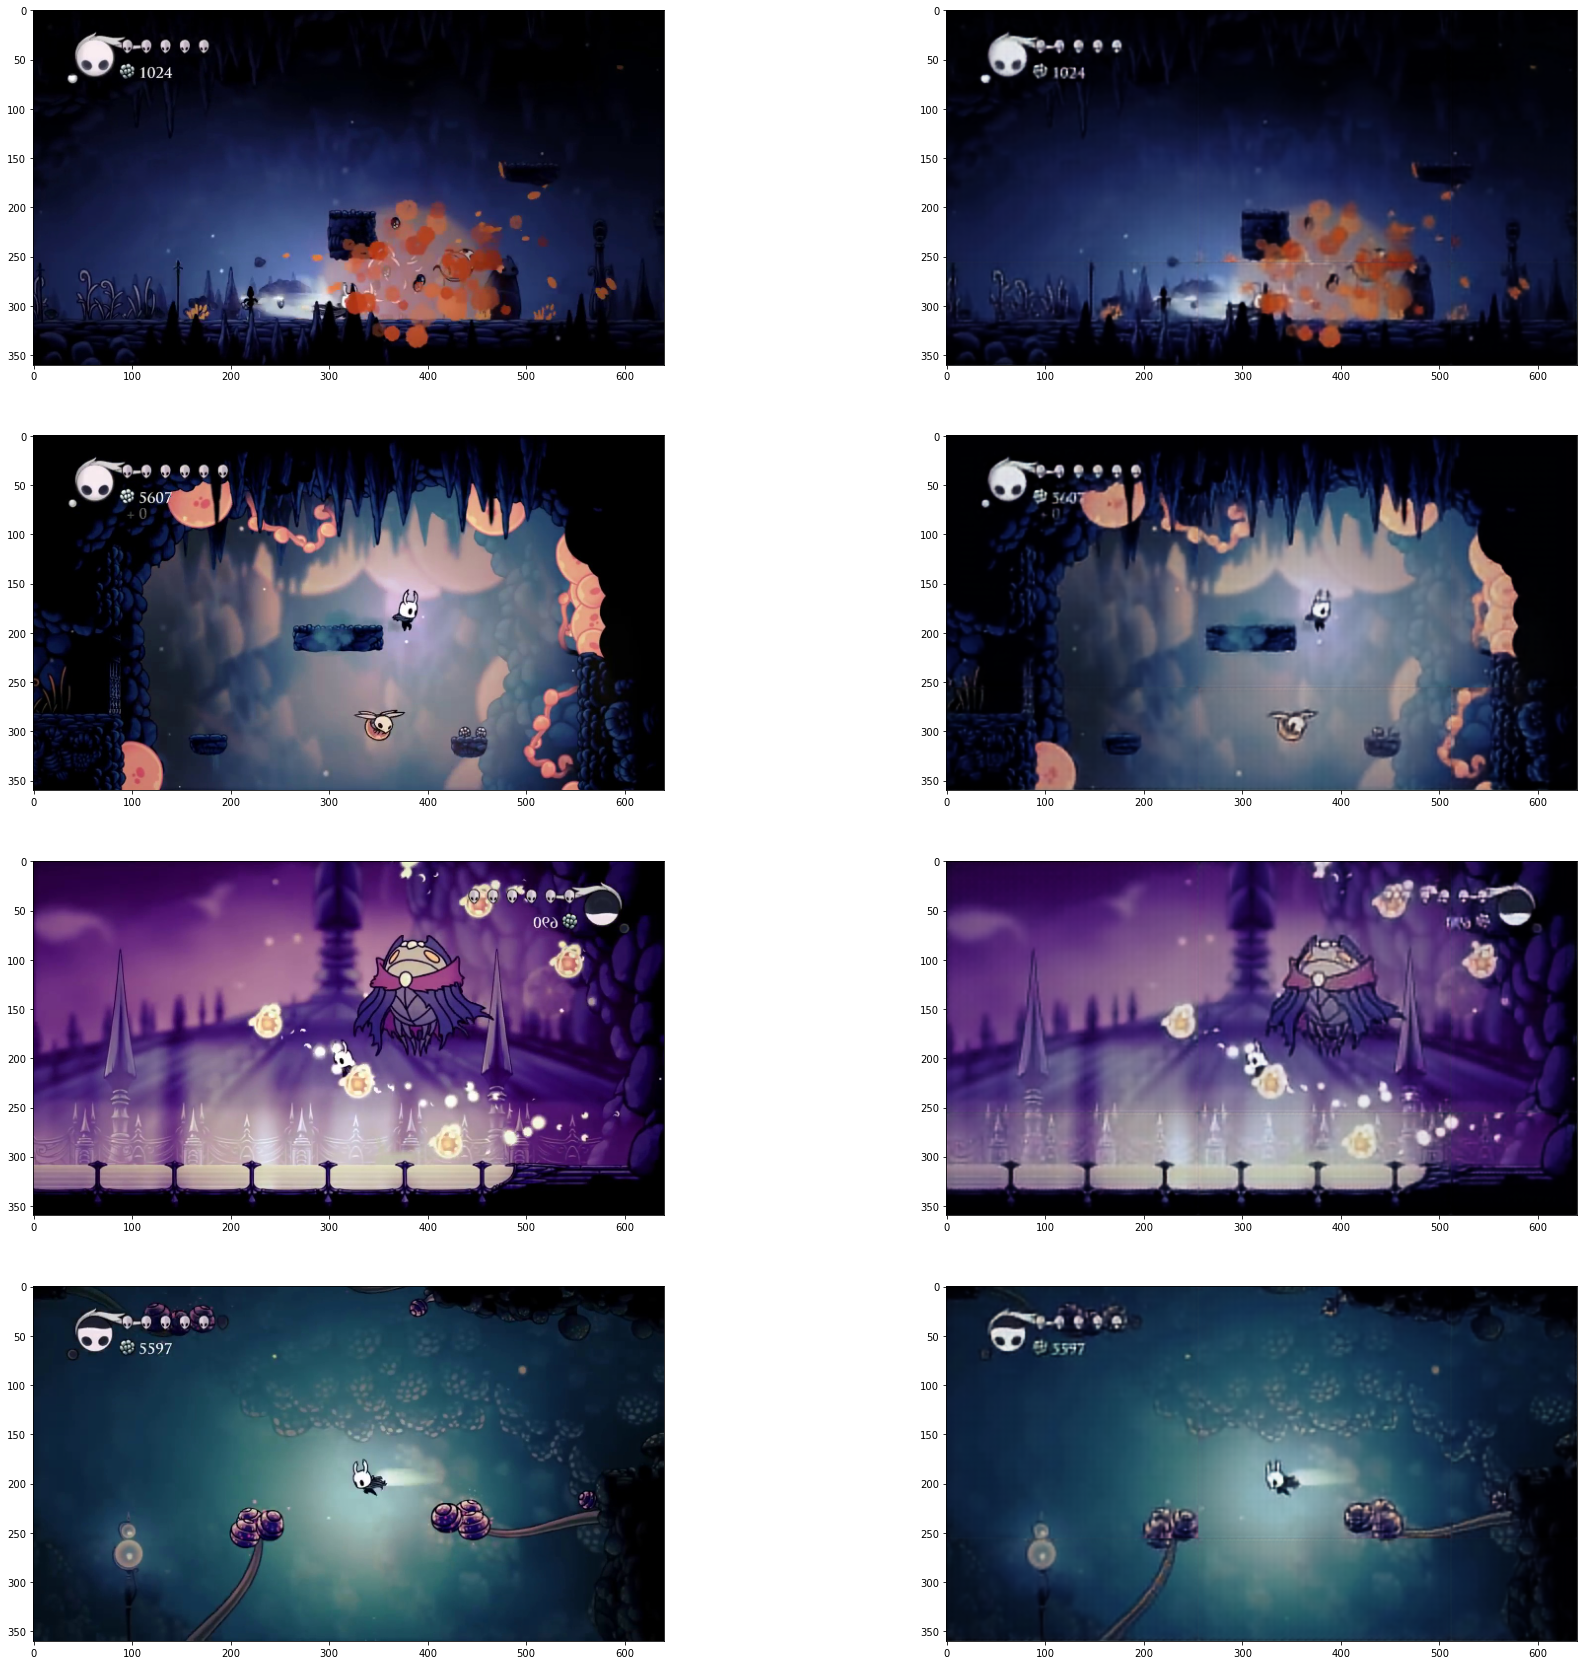

In [53]:
import numpy as np

img_size = (image_height_target, image_width_target, 3)

fig = plt.figure(figsize=(30, 30))


ssim_values = []
for i in range(img_number):
    image_slices = test_set[i]

    decoded_slices = autoencoder.predict(image_slices)
    decoded_img = deslice_img(decoded_slices, img_size)
    decoded_img = decenter_img(decoded_img)

    original_image = decenter_img(deslice_img(image_slices, img_size))

    ssim = 1 - tensorflow.image.ssim_multiscale(original_image, decoded_img, 1.0, filter_size=3)
    ssim_values.append(ssim)
    print(ssim.numpy())

    if i < display_img_number:
        plt.subplot(display_img_number, 2, i*2+1)
        plt.imshow(original_image)
        plt.subplot(display_img_number, 2, i*2+2)
        plt.imshow(decoded_img)

print("AVERAGE SSIM: ")
print(np.array(ssim_values).mean())

# rescaled_img = cv2.resize(decenter_img(in_img), (in_img.shape[0] // 3, in_img.shape[1] // 3))

1/1 [==============================] - 0s 26ms/step


ValueError: num must be 1 <= num <= 8, not 9

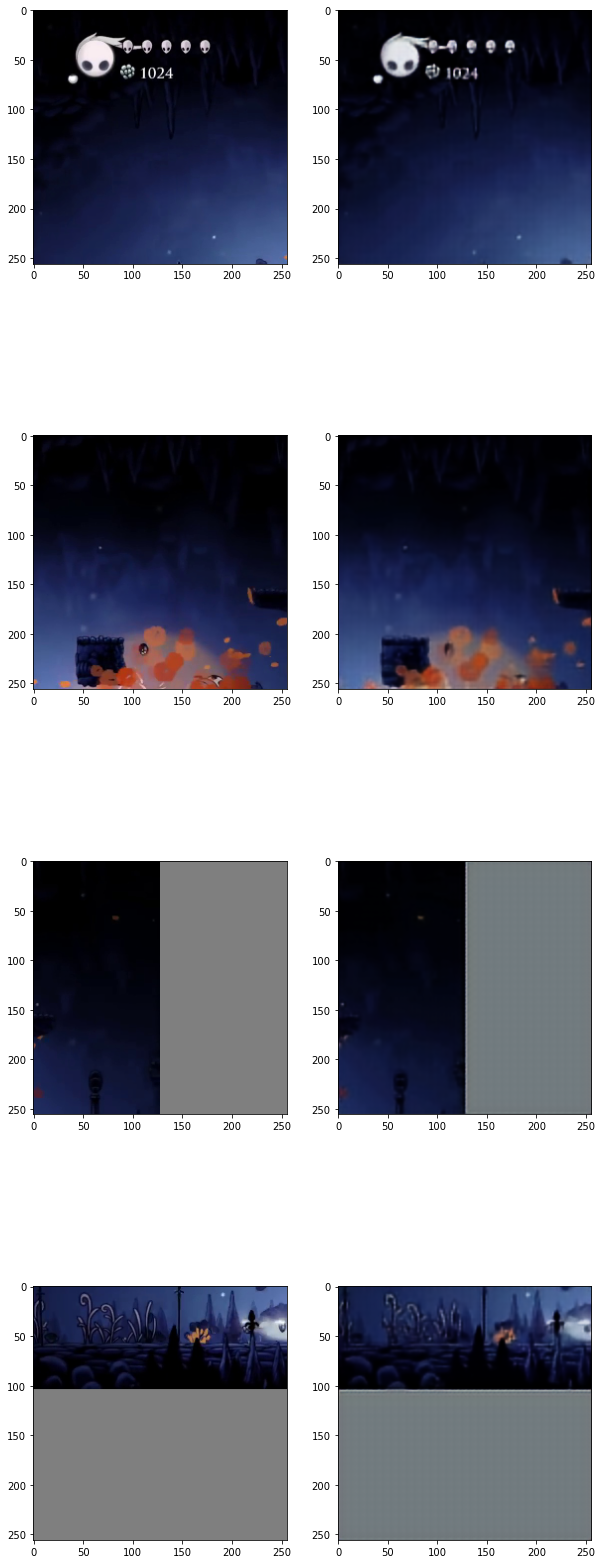

In [64]:
img_size = (image_height_target, image_width_target, 3)

fig = plt.figure(figsize=(10, 30))


image_slices = test_set[0]
decoded_slices = autoencoder.predict(image_slices)

for i in range(len(decoded_slices)):
    original_image = decenter_img(decoded_slices[i])

    plt.subplot(display_img_number, 2, i*2+1)
    plt.imshow(decenter_img(test_set[0][i]))
    plt.subplot(display_img_number, 2, i*2+2)
    plt.imshow(decenter_img(decoded_slices[i]))

# rescaled_img = cv2.resize(decenter_img(in_img), (in_img.shape[0] // 3, in_img.shape[1] // 3))